In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2D Incompressible Navier-Stokes
Special geometry (periodic at $[0, 2\pi]^2$]
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} =
- \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} =
- \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

### Incompressibility condition
$ \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $

### Analytical solution (for comparison & benchmarking)
$ \begin{aligned}
u(x, y, t) &= -\cos(x)\sin(y) \cdot e^{-2\nu t} \\
v(x, y, t) &= \sin(x)\cos(y) \cdot e^{-2\nu t} \\
p(x, y, t) &= -\frac{1}{4} \left( \cos(2x) + \cos(2y) \right) \cdot e^{-4\nu t}
\end{aligned} $

## Example plot (analytical solution)

In [2]:
# Parameter
nu = 0.01 # Viscosity
t = 1.0 # Time

# 2D-Grid
N = 50
x = np.linspace(0, 2*np.pi, N)
y = np.linspace(0, 2*np.pi, N)
X, Y = np.meshgrid(x, y)
print(X.shape)

# Analytical solution
u = -np.cos(X) * np.sin(Y) * np.exp(-2 * nu * t)
v = np.sin(X) * np.cos(Y) * np.exp(-2 * nu * t)
p = -0.25 * (np.cos(2*X) + np.cos(2*Y)) * np.exp(-4 * nu * t)
print(p.shape)

(50, 50)
(50, 50)


Plotting (static for t=1.0)

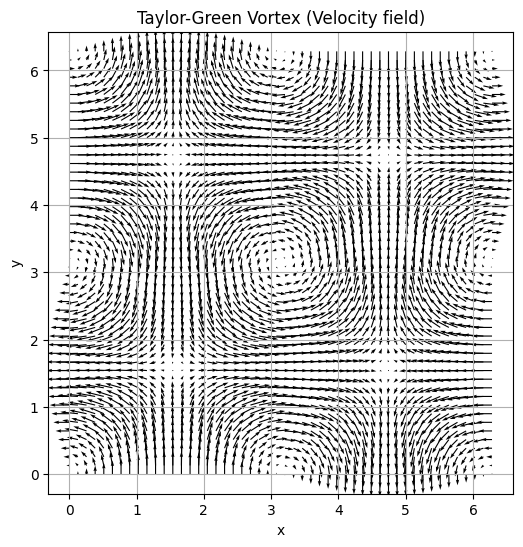

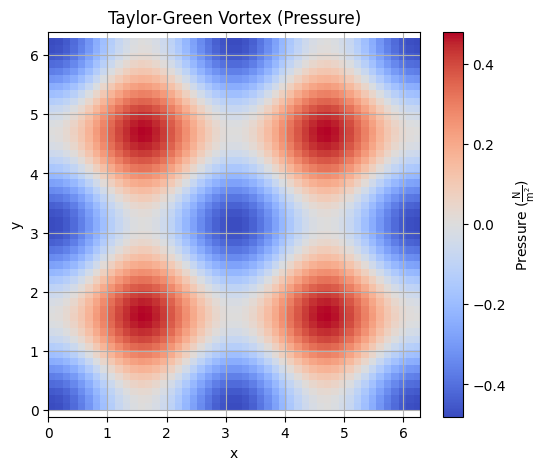

In [3]:
# Plot Velocity field
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, u, v, scale=20)
plt.title('Taylor-Green Vortex (Velocity field)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

# Plot Pressure
plt.figure(figsize=(6, 5))
#plt.contourf(X, Y, p, cmap='coolwarm')
plt.imshow(p, extent=[0, 2*np.pi, 0, 2*np.pi], origin='lower', cmap='coolwarm')
plt.colorbar(label=r'Pressure ($\frac{\mathrm{N}}{\mathrm{m}^2}$)')
plt.title('Taylor-Green Vortex (Pressure)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

Plotting (dynamic animation)

In [ ]:
t_start = 0
t_end = 75
n_frames = 75  # = 1 Frame pro Sekunde simuliert, aber:
times = np.linspace(t_start, t_end, n_frames)

desired_duration_sec = 5.0
fps = n_frames / desired_duration_sec

# Plot Setup
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(np.zeros_like(X), extent=[0, 2*np.pi, 0, 2*np.pi],
                origin='lower', cmap='coolwarm', vmin=-0.5, vmax=0.5)
quiv = ax.quiver(X, Y, np.zeros_like(X), np.zeros_like(Y), scale=20)
cb = plt.colorbar(img, ax=ax, label=r'Pressure ($\frac{\mathrm{N}}{\mathrm{m}^2}$)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('equal')
ax.grid()

# Update function
def update(i):
    t = times[i]

    u = -np.cos(X) * np.sin(Y) * np.exp(-2 * nu * t)
    v = np.sin(X) * np.cos(Y) * np.exp(-2 * nu * t)
    p = -0.25 * (np.cos(2*X) + np.cos(2*Y)) * np.exp(-4 * nu * t)

    img.set_data(p)
    quiv.set_UVC(u, v)

    ax.set_title(f't={t:.2f} s')
    return [img, quiv]

# Animation (interval in ms = 1000 / fps)
ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=1000 / fps, blit=False)

plt.close(fig)
HTML(ani.to_jshtml())

## Implementation of the PINN
Input:

$X = \begin{bmatrix} x \\ y \\ t \end{bmatrix}$

Output:

$\text{NN}(x, y, t) = \begin{bmatrix} u \\ v \\ p \end{bmatrix}$

Loss-Function:

$\mathcal{L}{\text{PINN}} = \mathcal{L}{\text{residuals}} + \lambda_{\text{data}} \cdot \mathcal{L}{\text{data}} + \lambda_{\text{bc}} \cdot \mathcal{L}_{\text{boundary}}$

In [4]:
class PINN(nn.Module):
  def __init__(self, hidden_dim=50, hidden_layers=5):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(3, hidden_dim), # Input: [t, x, y]
        nn.Tanh(), # Smooth activation function & good for regularization
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, 3) # Output: [u, v, p]
    )
  def forward(self, txy):
    return self.net(txy) # (N, 3) -> (N, 3)

## Preparation for the regularized loss

Generating collocation points

t ∈ [0, T], x ∈ [0, 2π], y ∈ [0, 2π]

In [5]:
# Boundaries
T = 1.0
N_colloc = 100_000

def sample_collocation_points(N, T=1.0):
    t = torch.rand(N, 1, device=device) * T
    x = torch.rand(N, 1, device=device) * (2 * torch.pi)
    y = torch.rand(N, 1, device=device) * (2 * torch.pi)
    return torch.cat([t, x, y], dim=1).requires_grad_(True)

def sample_collocation_points_grid(Nx=100, Ny=100, T=1.0):
    x = torch.linspace(0, 2 * torch.pi, Nx)
    y = torch.linspace(0, 2 * torch.pi, Ny)
    t = torch.rand(Nx * Ny, 1) * T

    X, Y = torch.meshgrid(x, y, indexing="ij")
    X = X.flatten().unsqueeze(1)
    Y = Y.flatten().unsqueeze(1)

    return torch.cat([t, X, Y], dim=1).to(device).requires_grad_(True)

In [6]:
def compute_residuals(model, txy, nu=0.01):
  if not txy.requires_grad:
      txy.requires_grad_(True)

  output = model(txy) # Output (N, 3) with u, v, p
  u, v, p = output[:, 0], output[:, 1], output[:, 2]

  # Calculate first gradients with respect to txy
  grad_u = torch.autograd.grad(u, txy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  grad_v = torch.autograd.grad(v, txy, grad_outputs=torch.ones_like(v), create_graph=True)[0]
  grad_p = torch.autograd.grad(p, txy, grad_outputs=torch.ones_like(p), create_graph=True)[0]

  # Extract individual first derivatives
  du_dt, du_dx, du_dy = grad_u[:, 0], grad_u[:, 1], grad_u[:, 2]
  dv_dt, dv_dx, dv_dy = grad_v[:, 0], grad_v[:, 1], grad_v[:, 2]
  dp_dt, dp_dx, dp_dy = grad_p[:, 0], grad_p[:, 1], grad_p[:, 2] # Although dp_dt is not used in PDE

  # Calculate second gradients
  d2u_dx2 = torch.autograd.grad(du_dx, txy, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 1] # Derivative of du_dx w.r.t x
  d2u_dy2 = torch.autograd.grad(du_dy, txy, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0][:, 2] # Derivative of du_dy w.r.t y

  d2v_dx2 = torch.autograd.grad(dv_dx, txy, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0][:, 1] # Derivative of dv_dx w.r.t x
  d2v_dy2 = torch.autograd.grad(dv_dy, txy, grad_outputs=torch.ones_like(dv_dy), create_graph=True)[0][:, 2] # Derivative of dv_dy w.r.t y

  # PDE-Residues
  res_u = du_dt + u * du_dx + v * du_dy + dp_dx - nu * (d2u_dx2 + d2u_dy2)
  res_v = dv_dt + u * dv_dx + v * dv_dy + dp_dy - nu * (d2v_dx2 + d2v_dy2)
  res_div = du_dx + dv_dy  # Divergence/incompressibility condition

  return res_u, res_v, res_div

Physics Loss with collocation points (for regularization)

In [7]:
def phys_loss(model, txy_colloc, nu=0.01):
  res_u, res_v, res_div = compute_residuals(model, txy_colloc, nu=nu)
  loss_u = torch.mean(res_u**2)
  loss_v = torch.mean(res_v**2)
  loss_div = torch.mean(res_div**2)
  return loss_u + loss_v + loss_div

### Total loss function

We have some information about our velocity field, but no information about the pressure. When learning we take a look at data we have and the differential equation relation between the parameter. Pressure will be learned implicitly through the residues of the Navier-Stokes equations ('physics loss')

In [8]:
def total_loss(model, txy_colloc, txy=None, uv=None, lambda_phys=1.0, nu=0.01):
  loss_phys = phys_loss(model, txy_colloc, nu=nu)

  if txy is not None and uv is not None:
    pred = model(txy)[:, :2] # Extract u, v
    loss = torch.mean((pred - uv) ** 2)
    return loss + lambda_phys * loss_phys

  return loss_phys

## Training the PNN

Let's assume we have gathered 100 measurements. Not to much, generally speaking for Neural Networks. However the regularization loss will allow our model to still grasp the physical correlation

In [9]:
def true_velocity(txy):
  t = txy[:, 0].unsqueeze(1)
  x = txy[:, 1].unsqueeze(1)
  y = txy[:, 2].unsqueeze(1)

  u = -torch.cos(x) * torch.sin(y) * torch.exp(-2 * nu * t)
  v = torch.sin(x) * torch.cos(y) * torch.exp(-2 * nu * t)
  return torch.cat([u, v], dim=1) # (N, 2)

In [11]:
N_data = 10000
txy_data = torch.rand(N_data, 3).to(device)
uv_data = true_velocity(txy_data).to(device)

In [12]:
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000
for epoch in range(n_epochs):
  optimizer.zero_grad()
  txy_colloc_epoch = sample_collocation_points_grid()
  loss = total_loss(model, txy_colloc_epoch, txy_data, uv_data, lambda_phys=10.0, nu=0.01)
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.265912
Epoch 100: Loss = 0.008569
Epoch 200: Loss = 0.001841
Epoch 300: Loss = 0.001060
Epoch 400: Loss = 0.000903
Epoch 500: Loss = 0.000544
Epoch 600: Loss = 0.000423
Epoch 700: Loss = 0.000403
Epoch 800: Loss = 0.000296
Epoch 900: Loss = 0.000261
Epoch 1000: Loss = 0.000275
Epoch 1100: Loss = 0.000217
Epoch 1200: Loss = 0.000257
Epoch 1300: Loss = 0.000243
Epoch 1400: Loss = 0.000180
Epoch 1500: Loss = 0.000175
Epoch 1600: Loss = 0.000202
Epoch 1700: Loss = 0.000173
Epoch 1800: Loss = 0.000471
Epoch 1900: Loss = 0.000220
Epoch 2000: Loss = 0.000160
Epoch 2100: Loss = 0.000154
Epoch 2200: Loss = 0.000153
Epoch 2300: Loss = 0.000138
Epoch 2400: Loss = 0.000148
Epoch 2500: Loss = 0.000198
Epoch 2600: Loss = 0.000152
Epoch 2700: Loss = 0.000188
Epoch 2800: Loss = 0.000136
Epoch 2900: Loss = 0.000147
Epoch 3000: Loss = 0.000198
Epoch 3100: Loss = 0.000152
Epoch 3200: Loss = 0.000238
Epoch 3300: Loss = 0.000135
Epoch 3400: Loss = 0.000145
Epoch 3500: Loss = 0.000116
Epoc

## Plotting Analytic vs PINN

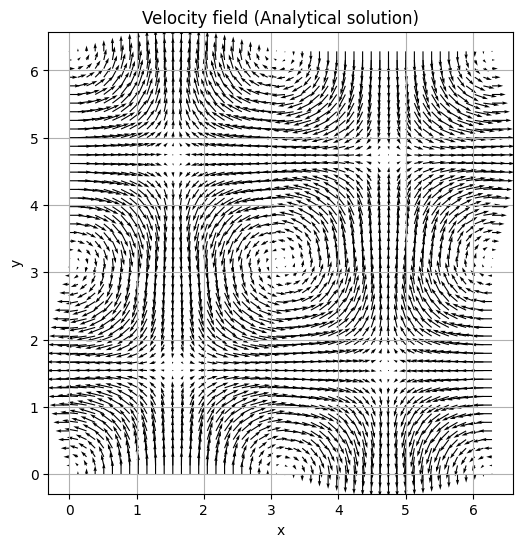

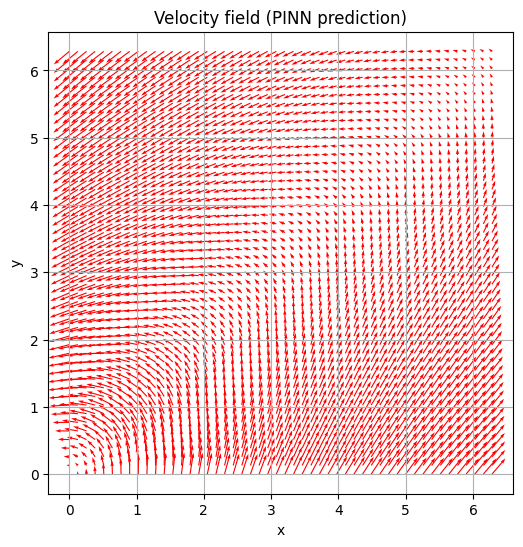

In [13]:
# Plot Velocity field (analytical)
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, u, v, scale=20)
plt.title('Velocity field (Analytical solution)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

# Plot Velocity field (PINN)
t_val = torch.full((N*N, 1), 1.0, dtype=torch.float32)
x_val = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)
txy_val = torch.cat([t_val, x_val, y_val], dim=1).to(device)

with torch.no_grad():
    pred = model(txy_val).cpu()
    u_pred = pred[:, 0].numpy().reshape(N, N)
    v_pred = pred[:, 1].numpy().reshape(N, N)

plt.figure(figsize=(6, 6))
plt.quiver(X, Y, u_pred, v_pred, scale=20, color='red')
plt.title('Velocity field (PINN prediction)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()